In [139]:
import numpy as np
import environment2
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss

In [140]:
env = environment2.environment2()
user_list_2D = env.user_list_2D

In [141]:
user_list_2D[0]

'data/NDSI-2D/U_1.csv'

In [142]:
fileNames2D=user_list_2D

In [143]:
fileNames2D

array(['data/NDSI-2D/U_1.csv', 'data/NDSI-2D/U_10.csv',
       'data/NDSI-2D/U_11.csv', 'data/NDSI-2D/U_12.csv',
       'data/NDSI-2D/U_13.csv', 'data/NDSI-2D/U_14.csv',
       'data/NDSI-2D/U_15.csv', 'data/NDSI-2D/U_16.csv',
       'data/NDSI-2D/U_17.csv', 'data/NDSI-2D/U_18.csv',
       'data/NDSI-2D/U_19.csv', 'data/NDSI-2D/U_2.csv',
       'data/NDSI-2D/U_20.csv', 'data/NDSI-2D/U_3.csv',
       'data/NDSI-2D/U_4.csv', 'data/NDSI-2D/U_5.csv',
       'data/NDSI-2D/U_6.csv', 'data/NDSI-2D/U_7.csv',
       'data/NDSI-2D/U_8.csv', 'data/NDSI-2D/U_9.csv'], dtype='<U21')

In [145]:
def get_probabilities(dataframe,phase):
    dataframe['high-level-action']=np.zeros(len(dataframe),str)
    probabilities=[]
    map=dict()
    # print(dataframe.head(5))
    states=['Sensemaking','Foraging','Navigation']
    actions=['change','same']
    for state in states:
      for action in actions:
        map[state+action]=0


    current_state=dataframe['State'][0]

    for i in range(1,len(dataframe)):
      if dataframe["State"][i]== current_state:
        dataframe["high-level-action"][i-1]="same"
      else:
        dataframe["high-level-action"][i-1]="change"
      current_state=dataframe["State"][i]
    dataframe["high-level-action"][len(dataframe)-1]="same"


    for i in range(len(dataframe)):
      if phase == 'Navigation' and dataframe['State'][i]=="Navigation":
        map[str(dataframe['State'][i]+dataframe['high-level-action'][i])] += 1
        probs = (map['Navigationsame'])/(map['Navigationchange']  + map['Navigationsame'])

      elif phase == 'Foraging' and dataframe['State'][i]=="Foraging":
        map[str(dataframe['State'][i]+dataframe['high-level-action'][i])] += 1
        probs = (map['Foragingsame'])/(map['Foragingchange'] + map['Foragingsame'])

      elif  phase == 'Sensemaking' and dataframe['State'][i]=="Sensemaking":
        map[str(dataframe['State'][i]+dataframe['high-level-action'][i])] += 1
        probs = (map['Sensemakingsame'])/(map['Sensemakingchange'] + map['Sensemakingsame'])
      probabilities.append(probs)
    dataframe['probabilities']=probabilities
    return dataframe, map

In [146]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        self.trend= None
    def kpss_test(self, timeseries):
        kpsstest = kpss(timeseries, regression="c", nlags="auto")
        kpss_output = pd.Series(
            kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
        )
        for key, value in kpsstest[3].items():
            kpss_output["Critical Value (%s)" % key] = value
        return kpss_output


In [147]:
for i, u in enumerate(fileNames2D):
    df = pd.read_csv(u)
    u = u.lstrip('data/NDSI-2D\\')
    u = u.rstrip('.csv')
    df_probab, _ = get_probabilities(df)
    if u=='U_11':
        test=df_probab

TypeError: get_probabilities() missing 1 required positional argument: 'phase'

In [135]:
test_subset=test[test['State'] == 'Sensemaking']
test_subset
kpss_stat, kpss_p_value, _, _ = kpss(test_subset['probabilities'])
# USER 11 AHS ALL 1 in Sensemaking always does SAME SAME SAME

/Users/aryal/anaconda3/envs/ForeCache-Master/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2114: RuntimeWarning: invalid value encountered in scalar divide
  s_hat = s1 / s0


ValueError: cannot convert float NaN to integer

In [150]:

# Create an empty list to store DataFrames
dfs = []
for i, u in enumerate(fileNames2D):
    df = pd.read_csv(u)
    u = u.lstrip('data/NDSI-2D\\')
    u = u.rstrip('.csv')

    # Create a list of DataFrames for each state
    state_dfs = []
    for state in df_probab['State'].unique():
        df_subset, _ = get_probabilities(df, str(state))
        assert(len(df_subset['probabilities'])==len(df))

        try:
            if not df_subset['probabilities'].empty and not df_subset['probabilities'].isnull().any():
                kpss_stat, kpss_p_value, _, _ = kpss(df_subset['probabilities'])

                # Create a DataFrame for the current state
                state_df = pd.DataFrame({'User': [u], 'State': [state], 'KPSS_Result': [kpss_p_value < 0.05]})
                state_dfs.append(state_df)
            else:
                print(f"User {u}, State {state}: Empty or contains null values in 'probabilities'")
        except Exception as e:
            print(f"Error processing User {u}, State {state}: {e}")
            # Create a DataFrame for the current state
            state_df = pd.DataFrame({'User': [u], 'State': [state], 'KPSS_Result': False})
            state_dfs.append(state_df)

    # Concatenate DataFrames for each state into a single DataFrame for the user
    user_df = pd.concat(state_dfs, ignore_index=True)
    dfs.append(user_df)

# Concatenate DataFrames for each user into the final DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Save results to CSV
results_df.to_csv('data/NDSI-2D/kpssresults.csv')



UnboundLocalError: local variable 'probs' referenced before assignment

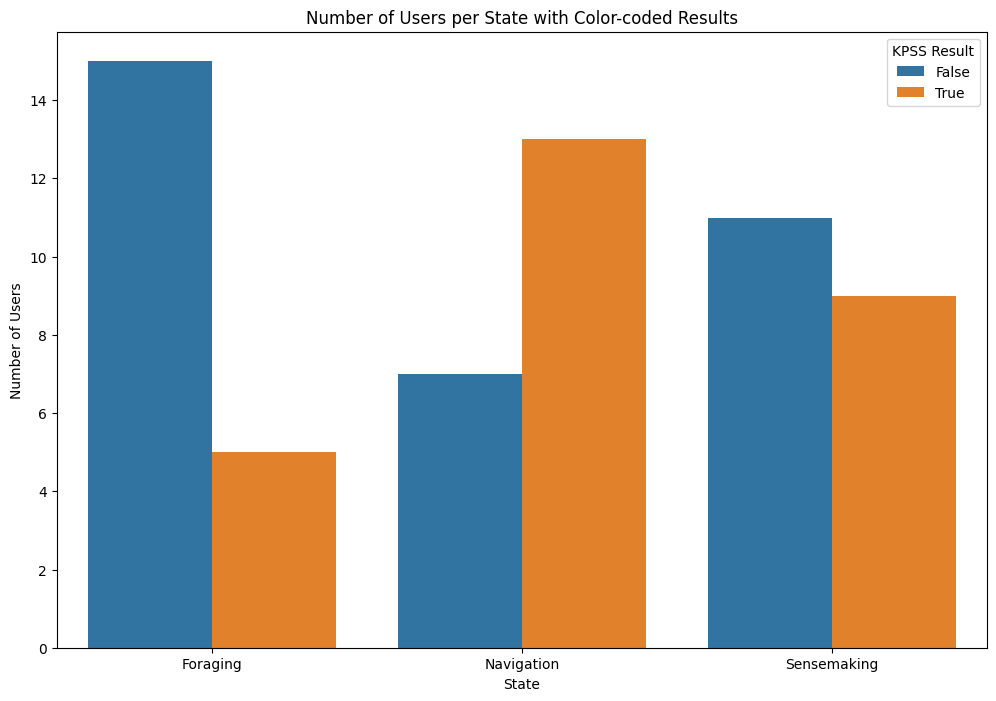

In [137]:
a
# Plotting
plt.figure(figsize=(12, 8))
sns.countplot(x='State', hue='KPSS_Result', data=results_df)
plt.title('Number of Users per State with Color-coded Results')
plt.xlabel('State')
plt.ylabel('Number of Users')
plt.legend(title='KPSS Result', loc='upper right', labels=['False', 'True'])
plt.show()